# Proterozoic Ocean Figures

This code reads the data in the "Data/Proterozoic Ocean model" folder and produces the figures from the corresponding figures of the main text and supplementary information. The data in the folder was produced by the Julia code "PO.jl". 

## Packages and functions,
(Run this before any other cell).

In [ ]:
#Packages
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({
    "font.family": "Helvetica",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Helvetica",
    "mathtext.it": "Helvetica:italic",
    "mathtext.bf": "Helvetica:bold",
    "font.size": 22,
    "axes.labelsize": 26,
    "axes.titlesize": 18,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
})
Broad_Coex="#edd2ceff" #Red
Coex_Bounded="#d2ebd2ff" #Green
Coex_Unbounded="#c7ddecff" #Blue
Dominance="#fbf3c4ff" #Yellow
No_MC="#f4f4f4ff" #Gray
Other="#c79cd2ff" #Purple
cmap = ListedColormap(["#FFFFFF", Broad_Coex, Coex_Unbounded, Coex_Bounded, Dominance, No_MC, Other])


Broad_Coex="#edd2ceff"
Coex_Bounded="#d2ebd2ff"
Coex_Unbounded="#c7ddecff"
Dominance="#fbf3c4ff"
No_MC="#d19856"
Other="#c79cd2ff"

region_to_color = {
    1: Broad_Coex,
    2: Coex_Unbounded,
    3: Coex_Bounded,
    4: Dominance,
    5: No_MC,
    6: Other,
}


#Classification Functions
def two_adjacent(Life_cycles):
    ones=np.where(Life_cycles == 1)[0]
    if ones.size==2:
        if ones[1]-ones[0]==1: return True
        else: return False
    else: return False

def classify(Life_cycles,N_L,NS):
    
    #dic={"Broad Coex": 1, "Coex Unbounded": 2, "Coex Bounded": 3, "Dominance": 4,"No Non_trivial MC": 5, "Other":6}

    life_cycles_present=np.sum(Life_cycles)
    small_life_cycles_present=np.sum(Life_cycles[:NS-1])   
    all_life_cycles=len(Life_cycles)

    # Broad coexistence:
    if life_cycles_present-small_life_cycles_present>2:
        if life_cycles_present==all_life_cycles: return 1 #All life cycles are present: broad coexistence
        elif np.all(Life_cycles[:N_L]==1) and np.all(Life_cycles[N_L:]==0): return 1 #All life cycles up to N_L are present: broad coexistence
        else: return 6 #Other; broad coexistence different from the ones above
    else:
        # Unbounded growth:
        if Life_cycles[-1]==1:
            if life_cycles_present>1: return 2 #unbounded growth with non-broad coexistence
            else: return 6 #Other; unbounded growth and dominance
        #Bounded:
        else:
            if life_cycles_present==small_life_cycles_present: return 5 #no non-trivial multicellularity
            elif life_cycles_present>0 and small_life_cycles_present>0: return 3 #bounded non-broad coexistence
            elif life_cycles_present>0 and small_life_cycles_present==0: 
                if life_cycles_present==1: return 4 #dominance
                elif two_adjacent(Life_cycles): return 4 #dominance, of two adjecent life cycles
                else: return 6 #Other
            else: return 6 #Other

def span_no_overlap(ax, x0, x1, color, alpha=0.25, zorder=0):

    x1_adj = np.nextafter(x1, x0)
    rect = patches.Rectangle(
        (x0, 0),                       
        x1_adj - x0, 1,                
        transform=ax.get_xaxis_transform(),
        facecolor=color, edgecolor=color, linewidth=0.5, 
        alpha=alpha, zorder=zorder
    )
    ax.add_patch(rect)

## NL x NU plot (Figure 5b and the first column of Figures S2,S3 and S4).

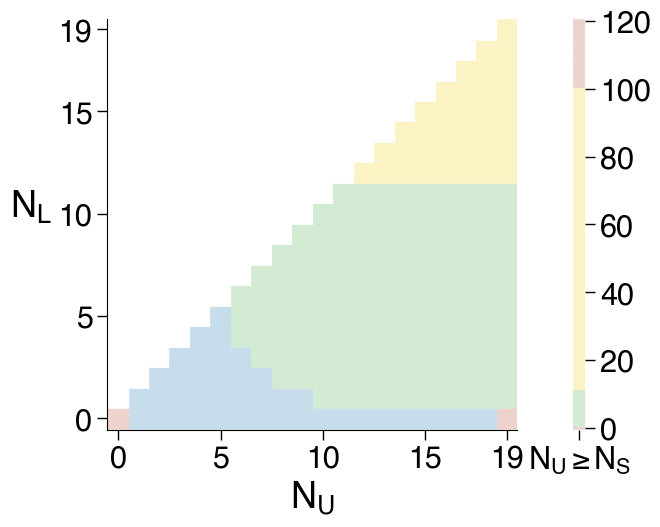

In [ ]:
#See Figure 5a at the last cell of this manuscript.

#Parameters. Chose the set of parameters you want to plot. See options below,

qB=0.0 #fixed
NS=20 # 20 for N+1 and N+N, 10 for Nx1
NE=120 #fixed
gamma=1 #fixed
r_o=6.8 #fixed
r_f=1 # 1 for all life cycles; N+1 also takes 0.01, 2, 3, 4, 5, and 6.
LCtype='N+1' # 'N+1', 'Nx1' or 'N+N'

# Load results
folder= Path("data") / "Proterozoic Ocean model"
results= pd.read_csv(folder / f"results_LC{LCtype}_mixing{qB}_NS{NS}_Nmax{NE}_gamma{gamma}_ro6p8_rf{r_f}.csv")


#First, for N_U<NS:
# Create mesh of NL (rows) and NU (columns)
NL_vals = np.arange(0, NS)
NU_vals = np.arange(0, NS)
NU_mesh, NL_mesh = np.meshgrid(NU_vals, NL_vals, indexing="xy")
# Create empty grid to store classifications
grid = np.zeros(( len(NL_vals), len(NU_vals)), dtype=int)


#Classify N_L-N_U combinations 
for i in range(len(NU_vals)):
    for j in range(len(NL_vals)):
        N_U=NU_vals[i]
        N_L=NL_vals[j]

        if N_L > N_U:
            continue

        row = results[(results["N_U"] == N_U) & (results["N_L"] == N_L)].to_numpy()[0]
        Life_cycles=row[11:]

        grid[j, i] = classify(Life_cycles,N_L,NS)



#Second, for N_U>=NS:
NL_vals_2 = np.arange(0, 121)
NU_vals_2 = np.arange(20, 20+1)
NU_mesh_2, NL_mesh_2 = np.meshgrid(NU_vals_2, NL_vals_2, indexing="xy")
grid_2 = np.zeros(( len(NL_vals_2), len(NU_vals_2)), dtype=int)

for i in range(len(NU_vals_2)):
    for j in range(len(NL_vals_2)):
        N_U=NU_vals_2[i]
        N_L=NL_vals_2[j]

        row = results[(results["N_U"] == N_U) & (results["N_L"] == N_L)].to_numpy()[0]
        Life_cycles=row[11:]

        grid_2[j, i] = classify(Life_cycles,N_L,NS)


# Plotting

fig = plt.figure(figsize=(10.33, 5.33))
gs = gridspec.GridSpec(
    1, 2,
    width_ratios=[19, 1],
    wspace=-0.5
)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# N_U<NS panel
n_rows, n_cols = grid.shape
for j in range(n_rows):
    for i in range(n_cols):
        val = grid[j, i]
        color = cmap(val) if 0 <= val < cmap.N else (1, 1, 1, 1)
        rect = patches.Rectangle(
            (i, j), 1, 1,
            facecolor=color, edgecolor=color, linewidth=0.5, alpha=1,
        )
        ax1.add_patch(rect)

ax1.set_xlim(-0.05, n_cols)
ax1.set_ylim(-0.05, n_rows)
ax1.set_aspect('equal', adjustable='box')

if LCtype=='Nx1':
    xticks = [0.5,2.5,4.5,6.5,8.5]
    yticks = [0.5,2.5,4.5,6.5,8.5]
    ax1.set_xticklabels([0,2,4,6,8])
    ax1.set_yticklabels([0,2,4,6,8])
else:
    xticks = [0.5,5.5,10.5,15.5,19.5]
    yticks = [0.5,5.5,10.5,15.5,19.5]
    ax1.set_xticklabels([0,5,10,15,19])
    ax1.set_yticklabels([0,5,10,15,19])
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xlabel(r"$N_U$")
ax1.set_ylabel(r"$N_L$", rotation=0, labelpad=20)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.tick_params(axis='both', length=7, width=1)


# N_U>=NS panel
n_rows2, n_cols2 = grid_2.shape
for j in range(n_rows2):
    for i in range(n_cols2):
        val = grid_2[j, i]
        color = cmap(val) if 0 <= val < cmap.N else (1, 1, 1, 1)
        rect = patches.Rectangle(
            (i, j), 1, 1,
            facecolor=color, edgecolor=color, linewidth=0.5, alpha=1,
        )
        ax2.add_patch(rect)

ax2.set_xlim(-0.05, n_cols2 + 0.05)
ax2.set_ylim(-0.05, n_rows2 + 0.05)
ax2.set_aspect(0.3, adjustable='box')

ax2.set_xticks([0.5])
ax2.set_xticklabels([r"$N_U \geq N_S$"])

yticks = np.arange(0.5, 121, 20)
ax2.set_yticks(yticks)
ax2.set_yticklabels([0, 20, 40, 60, 80, 100, 120])

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.tick_params(axis='both', length=7, width=1)

plt.show()


## Figure 5c and second column of Figures S2, S3, and S4. 

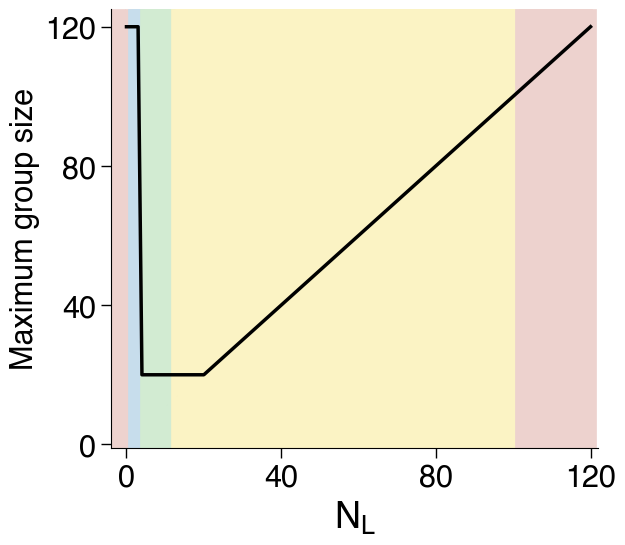

In [15]:
# Parameters

qB = 0.0 #fixed
NS = 20 # 20 for N+1 and N+N, 10 for Nx1
NE = 120 #fixed
gamma = 1 #fixed
r_o = 6.8 #fixed
r_f = 1 # 1 for all life cycles; N+1 also takes 0.01, 1, 2, 3, 4, 5, and 6.
LCtype = 'N+1' # 'N+1', 'Nx1' or 'N+N'

# Load results
folder= Path("data") / "Proterozoic Ocean model"
results= pd.read_csv(folder / f"results_LC{LCtype}_mixing{qB}_NS{NS}_Nmax{NE}_gamma{gamma}_ro6p8_rf{r_f}.csv")

# Identify LC columns
lc_cols = [c for c in results.columns if c.startswith("LC_")]

# Since we have N_U= 2N_U, we first compute the target_NU for each row
# - If 2*N_L <= NS - 1, use N_U = 2*N_L
# - Otherwise, use N_U = 20
results = results.copy()
results["target_NU"] = results["N_L"].apply(
    lambda nl: 2 * nl if 2 * nl <= NS - 1 else 20
)

# Filter to the desired NL–NU pairs
results_filtered = results[results["N_U"] == results["target_NU"]]

# Sort by NL
results_filtered = results_filtered.sort_values("N_L")

NL_list = []
maxLC_list = []
region_list = []

for _, row in results_filtered.iterrows():
    N_L = int(row["N_L"])
    LC_values = row[lc_cols].values
    
    # max LC present
    max_LC_val = np.where(LC_values == 1)[0].max() + 1
    
    # classification
    reg = classify(LC_values, N_L, NS)
    
    # Store
    NL_list.append(N_L)
    maxLC_list.append(max_LC_val)
    region_list.append(reg)

# Save classification for plotting
max_LC = pd.DataFrame({
    "N_L": NL_list,
    "max_LC": maxLC_list,
    "region": region_list
}).sort_values("N_L")


# Plot
fig, ax = plt.subplots(figsize=(8*5/6, 7.1*5/6))
ax.set_aspect('equal', adjustable='box')
ax.set_aspect(0.9)

if 0 in max_LC["N_L"].values:    
    region0 = int(max_LC.loc[max_LC["N_L"] == 0, "region"].iloc[0])
    color0 = region_to_color.get(region0, None)
    if color0 is not None:
        span_no_overlap(ax, -1e9, -0.5, color0, alpha=1, zorder=0)

for _, row in max_LC.iterrows():
    NL = row["N_L"]
    reg = row["region"]
    if pd.isna(reg):
        continue
    reg = int(reg)
    color = region_to_color.get(reg, None)
    if color is None:
        continue

    span_no_overlap(ax, NL - 0.5, NL + 1.5, color, alpha=1, zorder=0)


ax.plot(max_LC["N_L"], max_LC["max_LC"], lw=2.5, color="black", zorder=5)

ax.set_xlabel(r"$N_L$")
ax.set_ylabel("Maximum group size",fontsize=22)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

xmin = max(0, np.nanmin(max_LC["N_L"])) if len(max_LC) else 0
xmax = max(120, np.nanmax(max_LC["N_L"])) if len(max_LC) else 120
ymax = np.nanmax(max_LC["max_LC"]) if np.isfinite(np.nanmax(max_LC["max_LC"])) else 0
ax.set_xlim(-4, xmax + 2)
ax.set_ylim(-1, ymax + 5)

xticks = [0,40,80,120]
yticks = [0,40,80,120]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis='both', length=7, width=1)

plt.tight_layout()
plt.show()


## Final column of Figures S2, S3, and S4.

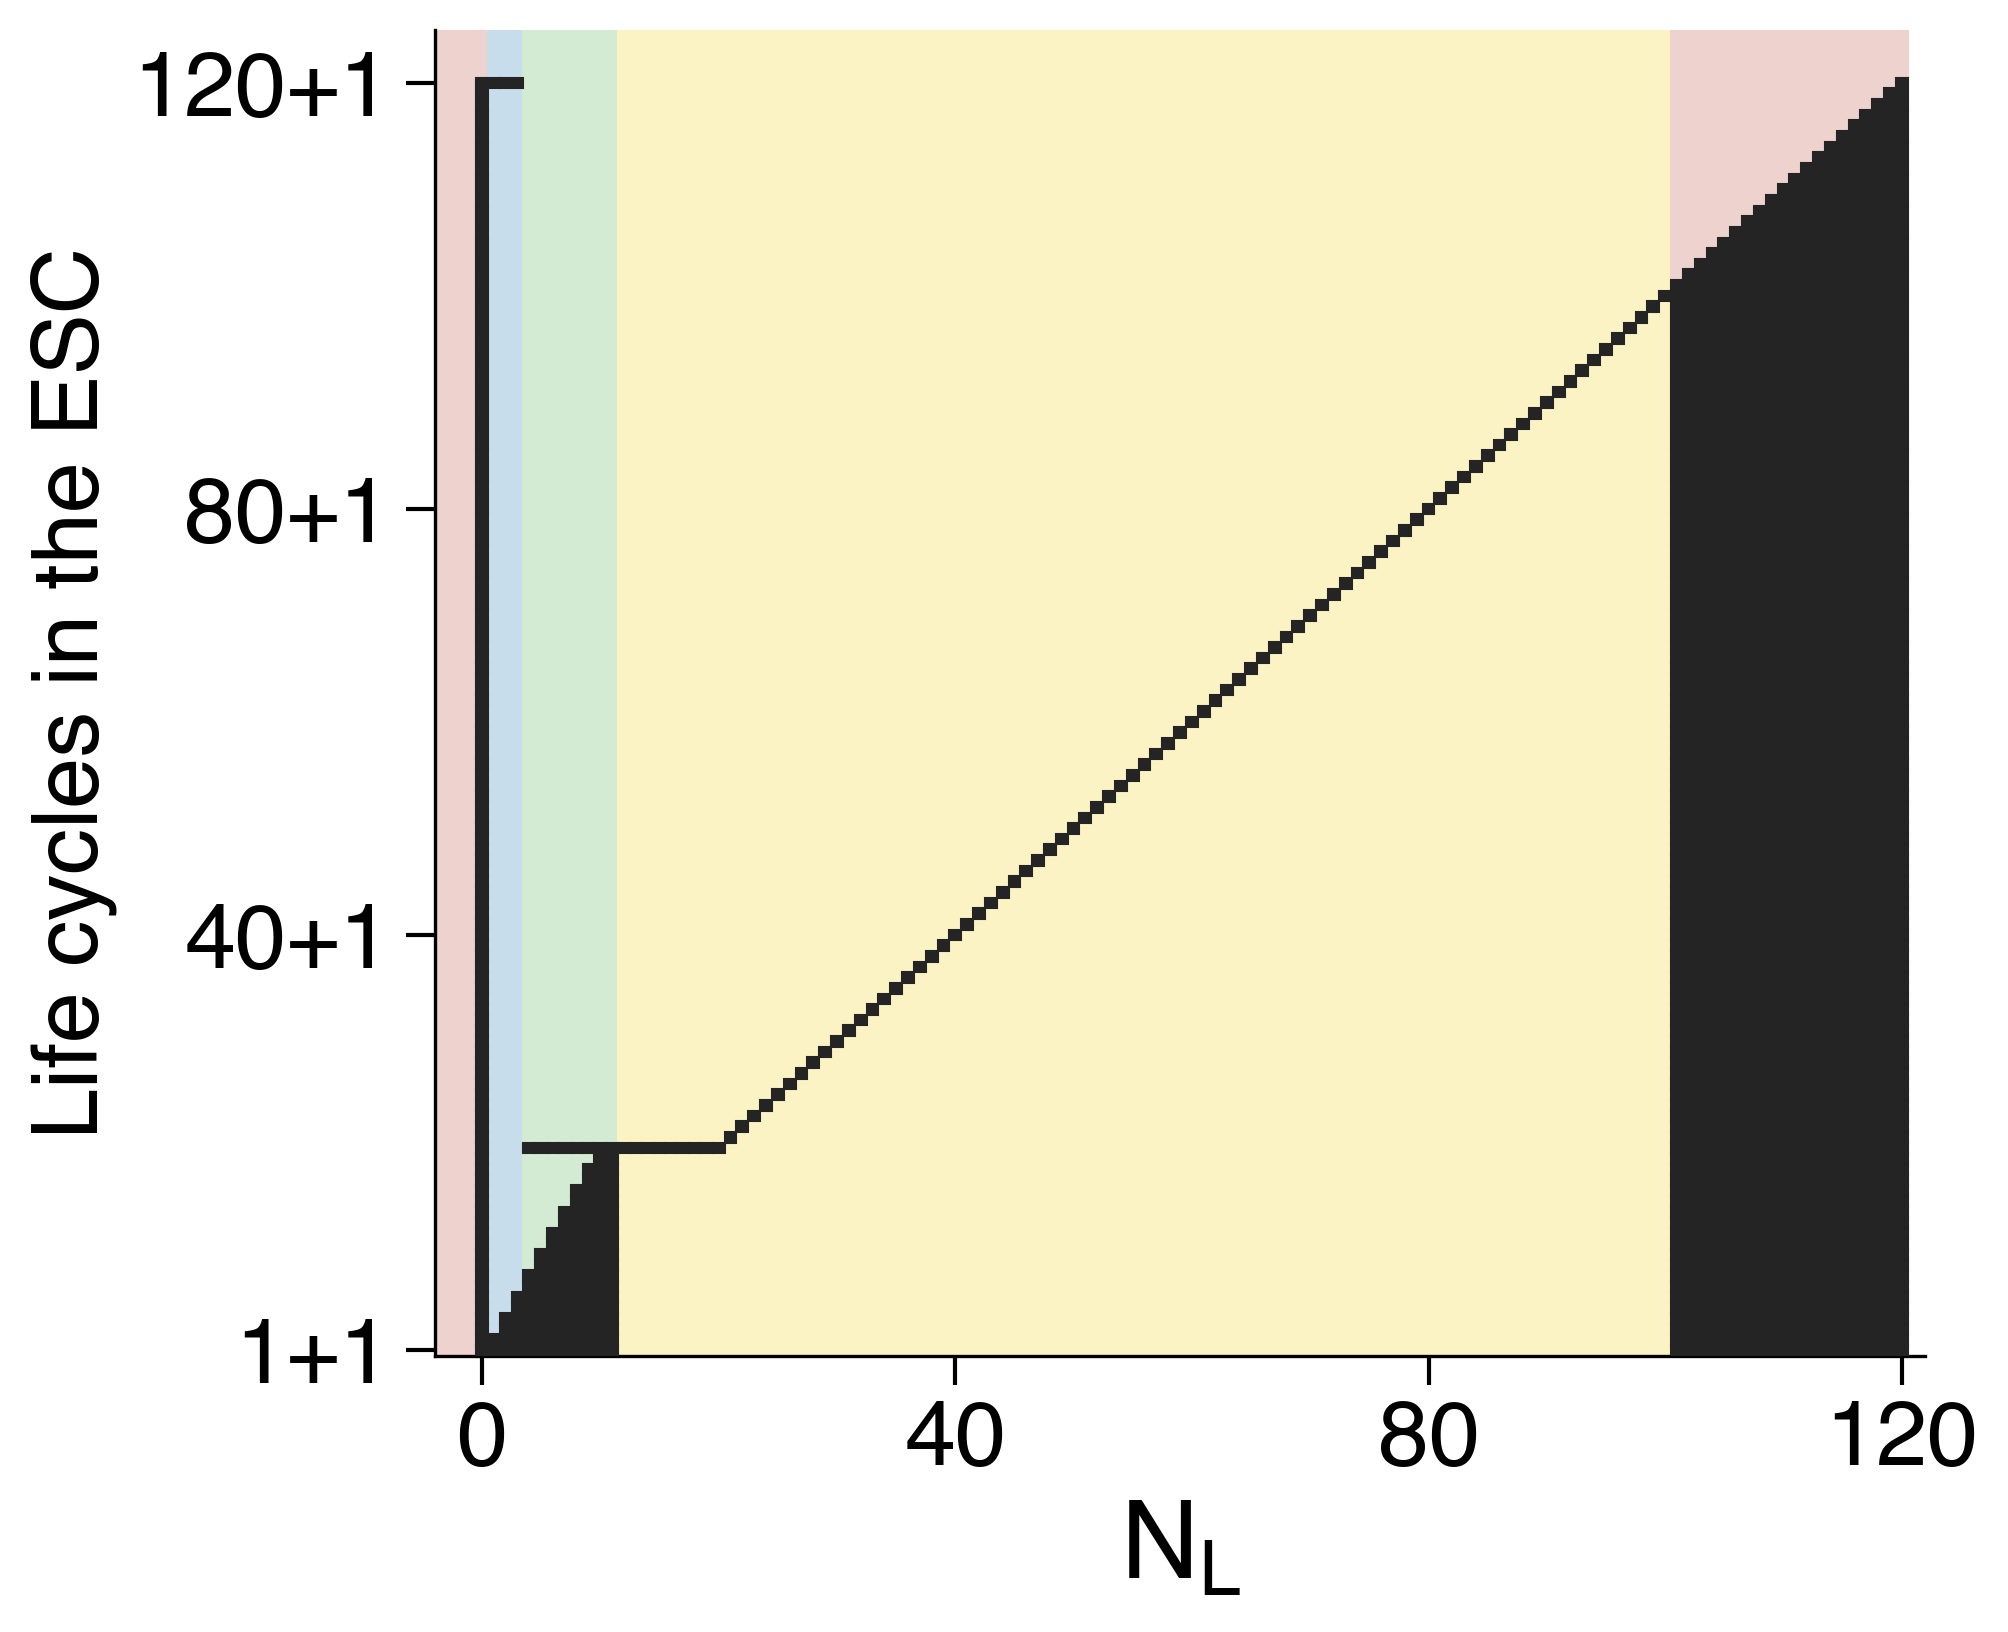

In [18]:
# Parameters

qB     = 0.0 #fixed
NS     = 20 # 20 for N+1 and N+N, 10 for Nx1
NE     = 120 #fixed
gamma  = 1 #fixed
r_o    = 6.8 #fixed
r_f    = 1 # 1 for all life cycles; N+1 also takes 0.01, 1, 2, 3, 4, 5, and 6.
LCtype = 'N+1'  # 'N+1', 'Nx1' or 'N+N'


# Load results
folder= Path("data") / "Proterozoic Ocean model"
results= pd.read_csv(folder / f"results_LC{LCtype}_mixing{qB}_NS{NS}_Nmax{NE}_gamma{gamma}_ro6p8_rf{r_f}.csv")

# Identify LC columns
lc_cols = [c for c in results.columns if c.startswith("LC_")]


# Choose target N_U for each N_L
results = results.copy()
results["target_NU"] = results["N_L"].apply(
    lambda nl: 2 * nl if 2 * nl <= NS - 1 else 20
)

# Filter to the desired N_L–N_U pairs
results_filtered = results[results["N_U"] == results["target_NU"]]

# Sort by N_L
results_filtered = results_filtered.sort_values("N_L")


# Classify 
NL_list    = []
maxLC_list = []
region_list = []

for _, row in results_filtered.iterrows():
    N_L = int(row["N_L"])
    LC_values = row[lc_cols].values

    # max LC present
    max_LC_val = np.where(LC_values == 1)[0].max() + 1

    # classification (assume classify is defined elsewhere)
    reg = classify(LC_values, N_L, NS)

    NL_list.append(N_L)
    maxLC_list.append(max_LC_val)
    region_list.append(reg)

# Save classification for plotting
max_LC = pd.DataFrame({
    "N_L": NL_list,
    "max_LC": maxLC_list,
    "region": region_list
}).sort_values("N_L")


# Plot
fig, ax = plt.subplots(figsize=(8*7.1/8, 7.1*7.1/8),dpi=300)
ax.set_aspect(0.9,adjustable='box')

if 0 in max_LC["N_L"].values:
    region0 = int(max_LC.loc[max_LC["N_L"] == 0, "region"].iloc[0])
    color0 = region_to_color.get(region0, None)
    if color0 is not None:
        span_no_overlap(ax, -1e9, -0.5, color0, alpha=1, zorder=0)


for _, row in max_LC.iterrows():
    NL = row["N_L"]
    reg = row["region"]
    if pd.isna(reg):
        continue
    reg = int(reg)
    color = region_to_color.get(reg, None)
    if color is None:
        continue

    span_no_overlap(ax, NL - 0.5, NL + 0.5, color, alpha=1, zorder=0)

for _, row in results_filtered.iterrows():
    NL = int(row["N_L"])
    LC_max = max_LC[max_LC["N_L"] == NL]["max_LC"].iloc[0]
    LC_values = row[lc_cols].values

    for k, val in enumerate(LC_values, start=1):
        if val == 1 and k == LC_max:
            square = patches.Rectangle(
                (NL - 0.5, k - 0.5),   
                1,                    
                1,                     
                facecolor='#242424ff',       
                edgecolor="#242424ff",
                zorder=4,
                alpha=1,
                linewidth=0.5 
            )
            ax.add_patch(square)
        
        elif val == 1 and k < LC_max:
            square = patches.Rectangle(
                (NL - 0.5, k - 0.5),   
                1,                    
                1,                     
                facecolor="#242424ff",       
                edgecolor="#242424ff",
                zorder=4,
                alpha=1,
                linewidth=0.5              
            )
            ax.add_patch(square)

ax.set_xlabel(r"$N_L$")
ax.set_ylabel("Life cycles in the ESC",fontsize=22)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ymax = np.nanmax(max_LC["max_LC"]) if np.isfinite(np.nanmax(max_LC["max_LC"])) else 0
ymax_int = int(ymax)



labels = []

if LCtype == 'N+1':
    yticks = [1,40,80,120]
    for k in yticks:
        labels.append(f"{k}+1")
elif LCtype == 'Nx1':
    yticks = [1,39,79,119]
    for k in yticks:
        labels.append(f"{k+1}x1")
elif LCtype == 'N+N':
    yticks = [1,39,79,119]
    for k in yticks:
        n = k + 1
        a = n // 2
        b = n - a
        labels.append(f"{b}+{a}")

ax.set_yticks(yticks)
ax.set_yticklabels(labels)



xmin = max(0, np.nanmin(max_LC["N_L"])) if len(max_LC) else 0
xmax = max(120, np.nanmax(max_LC["N_L"])) if len(max_LC) else 120
ymax = np.nanmax(max_LC["max_LC"]) if np.isfinite(np.nanmax(max_LC["max_LC"])) else 0
ax.set_xlim(-4, xmax + 2)
ax.set_ylim(0.5, ymax + 5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='both', length=7, width=1)

xticks = [0,40,80,120]
ax.set_xticks(xticks)


plt.tight_layout()
plt.show()


## Figure 5d

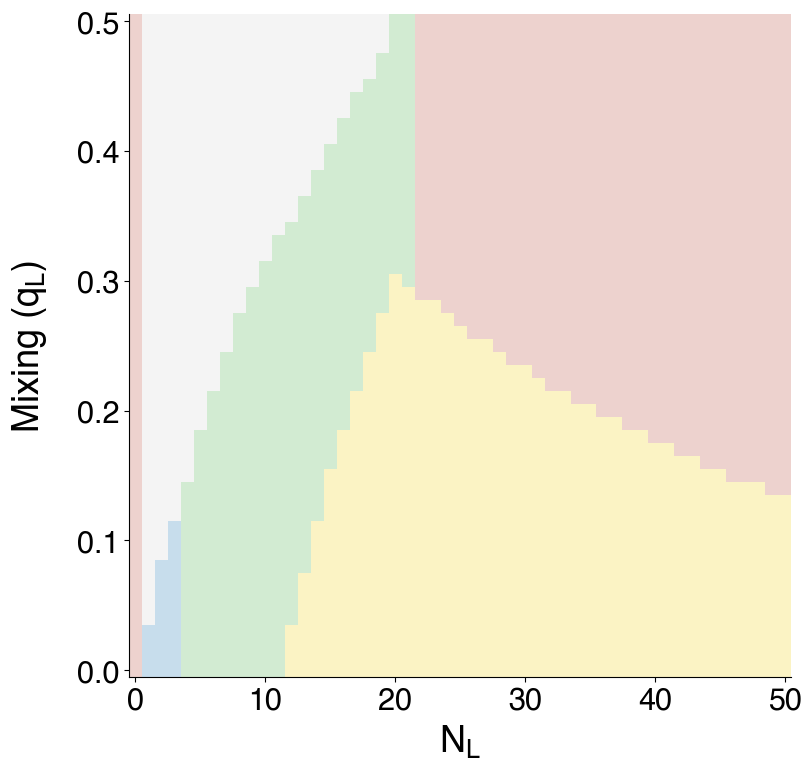

In [21]:
# Fixed set of parameters, do not change.
NS = 20
NE = 120
gamma = 1
r_o = 6.8
r_f = 1
LCtype = 'N+1'
qB = 'variable'

# Load results
folder = Path("data") / "Proterozoic Ocean model"
results_unsorted = pd.read_csv(
    folder / f"results_LC{LCtype}_mixing{qB}_NS{NS}_Nmax{NE}_gamma{gamma}_ro6p8_rf{r_f}.csv"
)
results = results_unsorted.sort_values(by=["mixing", "N_L"]).reset_index(drop=True)


NL_vals = np.arange(0, 51)
qL_vals = results["mixing"].unique()


qL_mesh, NL_mesh = np.meshgrid(qL_vals, NL_vals, indexing="xy")


grid_m = np.zeros((len(NL_vals), len(qL_vals)), dtype=int)

for i in range(len(qL_vals)):
    for j in range(len(NL_vals)):
        qL = qL_vals[i]
        N_L = NL_vals[j]

        row = results[(results["N_L"] == N_L) & (results["mixing"] == qL)].to_numpy()[0]
        Life_cycles = row[9:]

        grid_m[j, i] = classify(Life_cycles, N_L, NS)


def plot_grid_squares(grid, x, y, cmap, cell_size=1):
    n_rows, n_cols = grid.shape
    fig, ax = plt.subplots(figsize=(8, 8), layout="constrained")

    for j in range(n_rows):
        for i in range(n_cols):
            val = grid[j, i]
            color = cmap(val)
            rect = patches.Rectangle(
                (i * cell_size, j * cell_size),
                cell_size,
                cell_size,
                facecolor=color,
                edgecolor=color,
                linewidth=0,
            )
            ax.add_patch(rect)

    ax.set_xlim(0, n_cols * cell_size)
    ax.set_ylim(0, n_rows * cell_size)
    ax.set_aspect("equal", adjustable="box")

    xticks = np.arange(0.5 * cell_size, n_cols * cell_size, 10 * cell_size)
    yticks = np.arange(0.5 * cell_size, n_rows * cell_size, 10 * cell_size)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels((xticks - 0.5).astype(int))   # N_L values
    ax.set_yticklabels((yticks - 0.5) / 100)         # Mixing values

    ax.set_xlabel(r"$N_L$")
    ax.set_ylabel(r"Mixing ($q_L$)", rotation=90, labelpad=20)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    plt.show()


plot_grid_squares(grid_m.T, NL_vals, qL_vals, cmap, cell_size=1)


## Figure 5a

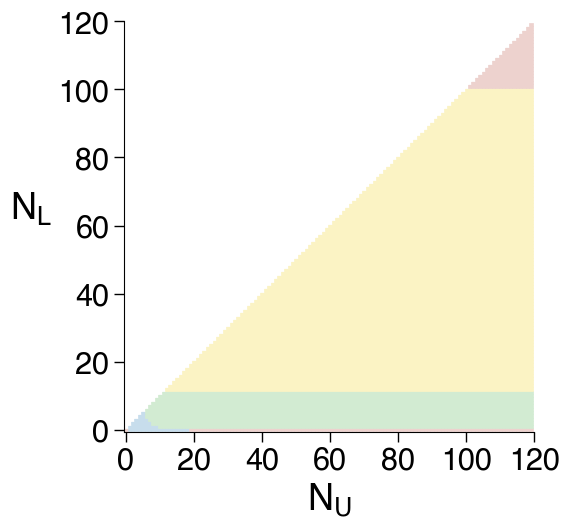

In [8]:
#The parameters below are fixed for this figure.

qB=0.0 #fixed
NS=20 #fixed
NE=120 #fixed
gamma=1 #fixed
r_o=6.8 #fixed
r_f=1 #fixed
LCtype='N+1'#fixed

# Load results
folder= Path("data") / "Proterozoic Ocean model"
results= pd.read_csv(folder / f"results_LC{LCtype}_mixing{qB}_NS{NS}_Nmax{NE}_gamma{gamma}_ro6p8_rf{r_f}.csv")



# Create mesh of NL (rows) and NU (columns)
N_boundary=120 #Change to shape the size of the axis. Default: N_boundary=20.
NL_vals = np.arange(0, N_boundary)
NU_vals = np.arange(0, N_boundary)
NU_mesh, NL_mesh = np.meshgrid(NU_vals, NL_vals, indexing="xy")
# Create empty grid to store classifications
grid = np.zeros(( len(NL_vals), len(NU_vals)), dtype=int)


#Classify N_L-N_U combinations 
for i in range(len(NU_vals)):
    for j in range(len(NL_vals)):
        N_U=NU_vals[i]
        N_L=NL_vals[j]

        if N_L > N_U:
            continue
        if N_U>NS:
            N_U=NS

        row = results[(results["N_U"] == N_U) & (results["N_L"] == N_L)].to_numpy()[0]
        Life_cycles=row[11:]

        grid[j, i] = classify(Life_cycles,N_L,NS)



# Plotting

fig, ax1 = plt.subplots(figsize=(10.33, 5.33))


# N_U<NS panel
n_rows, n_cols = grid.shape
for j in range(n_rows):
    for i in range(n_cols):
        val = grid[j, i]
        color = cmap(val) if 0 <= val < cmap.N else (1, 1, 1, 1)
        rect = patches.Rectangle(
            (i, j), 1, 1,
            facecolor=color, edgecolor=color, linewidth=0.5, alpha=1,
        )
        ax1.add_patch(rect)

ax1.set_xlim(-0.05,N_boundary+0.55)
ax1.set_ylim(-0.05, N_boundary+0.55)
ax1.set_aspect('equal', adjustable='box')

if LCtype=='Nx1' and N_boundary==20:
    xticks = [0.5,2.5,4.5,6.5,8.5]
    yticks = [0.5,2.5,4.5,6.5,8.5]
    ax1.set_xticklabels([0,2,4,6,8])
    ax1.set_yticklabels([0,2,4,6,8])
elif N_boundary==20:
    xticks = [0.5,5.5,10.5,15.5,19.5]
    yticks = [0.5,5.5,10.5,15.5,19.5]
    ax1.set_xticklabels([0,5,10,15,19])
    ax1.set_yticklabels([0,5,10,15,19])
else:
    xticks = np.arange(0.5, N_boundary+1, 20)
    yticks = np.arange(0.5, N_boundary+1, 20)
    ax1.set_xticklabels(np.arange(0, N_boundary+1, 20))
    ax1.set_yticklabels(np.arange(0, N_boundary+1, 20))
ax1.set_xticks(xticks)
ax1.set_yticks(yticks)
ax1.set_xlabel(r"$N_U$")
ax1.set_ylabel(r"$N_L$", rotation=0, labelpad=20)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.tick_params(axis='both', length=7, width=1)

plt.show()
